In [2]:
import re
import pandas as pd
import numpy as np
import scipy.stats
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
import fitter
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection import PageHinkley
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
from itertools import islice 
warnings.filterwarnings('ignore')
%matplotlib inline

### Data preparation

In [3]:
series1=pd.read_csv('data/series1.csv')
series2=pd.read_csv('data/series2.csv')
series3=pd.read_csv('data/series3.csv')

In [4]:
ser1_arr=np.asarray(series1.x.to_list())
ser2_arr=np.asarray(series2.x.to_list())
ser3_arr=np.asarray(series3.x.to_list())

In [5]:
test_data_stream = np.random.randint(2, size=2000)
for i in range(999, 2000):
    test_data_stream[i] = np.random.randint(4, high=8)
test_data_stream=test_data_stream.astype('float')

#### Basic stream simulator ( data series splited into into chunks of window size)

In [382]:
WINDOW_SIZE=100
WINDOWS_IN_BUFFER=5

In [383]:
def stream_splits(data,window_size):
    data_iter = iter(data) 
    lengths=[window_size for i in range(int(np.floor(len(data)/window_size)))]    
    if len(data) % window_size != 0:
        last=len(data)-window_size*(int(np.floor(len(data)/window_size))-1)
        print(last)
        lengths.append(last)
    output = [list(islice(data_iter, elem)) 
              for elem in lengths] 
    return output

In [384]:
STREAM_1=stream_splits(ser1_arr,WINDOW_SIZE)
STREAM_2=stream_splits(ser2_arr,WINDOW_SIZE)
STREAM_3=stream_splits(ser3_arr,WINDOW_SIZE)
STREAM_TEST=stream_splits(test_data_stream,1000)

#### Datset plots

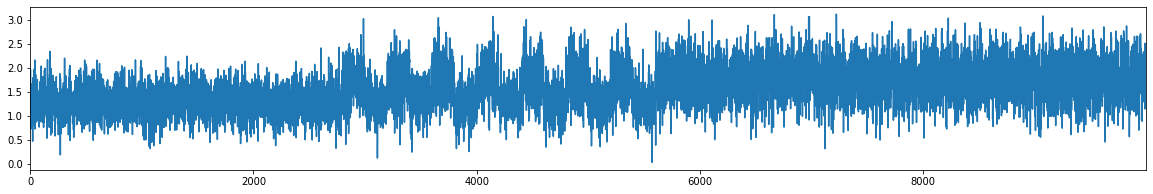

In [427]:
fig= plt.figure(figsize=(20,3))
series1.x.plot()

Series 1 resembles recurring concept drift

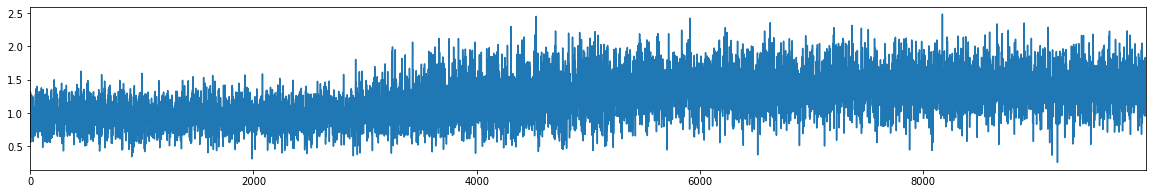

In [43]:
fig= plt.figure(figsize=(20,3))
series2.x.plot()

Series 2 resembles incremental concept drift

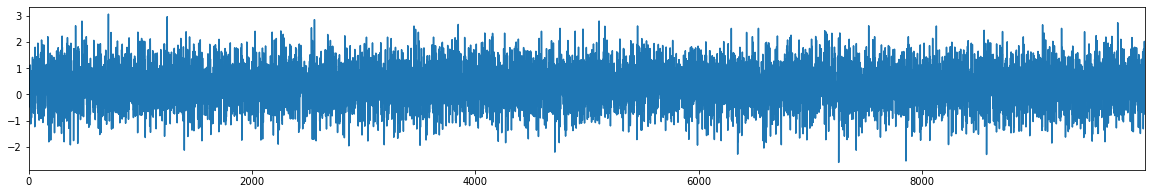

In [44]:
fig= plt.figure(figsize=(20,3))
series3.x.plot()

There is probably no concept drift in series 3

#### Within series plots

In [9]:
def plot_histogram_of_n_chunks(data_series, n):
    splitted_list=np.array_split(data_series, n)
    for part in splitted_list:
        counts, bins = np.histogram(part)
        plt.hist(bins[:-1], bins, weights=counts)

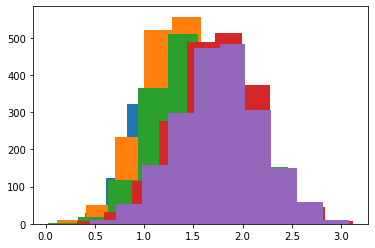

In [10]:
plot_histogram_of_n_chunks(ser1_arr,5)

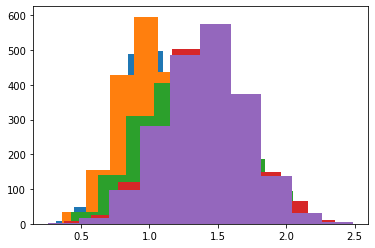

In [11]:
plot_histogram_of_n_chunks(ser2_arr,5)

Series 1 and 2 seem to come from multiple probability distributions

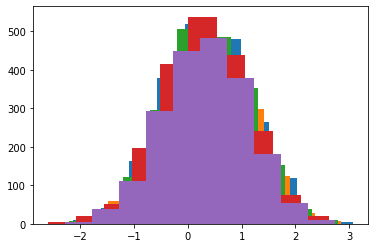

In [12]:
plot_histogram_of_n_chunks(ser3_arr,5)

Series 3 seem to come from single distribution

### Concept drift detection using external library

In [83]:
### Adaptive window detector 
def adwin_detector(data,printout=True):
    change_index_list=[]
    adwin = ADWIN()
    for i in range(len(data)):
        adwin.add_element(data[i])
        if adwin.detected_change():
            if printout:
                print('Change in data at value ' + str(data[i]) + ' - at index: ' + str(i))
            change_index_list.append(i)
    return change_index_list

In [84]:
### DDM (Drift Detection Method) detector 
def ddm_detector(data):
    ddm = DDM(min_num_instances=30,out_control_level=3.0)
    for i in range(len(data)):
        ddm.add_element(data[i])
        if ddm.detected_change():
            print('Change in data at value : ' + str(data[i]) + ' - of index: ' + str(i))

In [85]:
### EDDM (Early Drift Detection Method) detector 
def eddm_detector(data):
    eddm = EDDM()
    for i in range(len(data)):
        eddm.add_element(data[i])
        if eddm.detected_change():
            print('Change in data at value : ' + str(data[i]) + ' - of index: ' + str(i))

In [86]:
### Page-Hinkley detector 
def ph_detector(data,printout=True):
    change_index_list=[]
    ph = PageHinkley()
    for i in range(len(data)):
        ph.add_element(data[i])
        if ph.detected_change():
            if printout:
                print('Change in data at value ' + str(data[i]) + ' - at index: ' + str(i))
            change_index_list.append(i)
    return change_index_list

#### Single detectors results

In [150]:
def plot_series_with_single_data_changes(series,changes):
    print(changes)
    fig= plt.figure(figsize=(20,3))
    series.x.plot()
    plt.vlines(x=changes,ymin=min(series.x), ymax=max(series.x),colors='red')

###### Series 1

Change in data at value 1.40454019740779 - at index: 3007
Change in data at value 2.26367419316964 - at index: 3327
Change in data at value 1.4706711430980302 - at index: 3359
Change in data at value 1.4695198519572499 - at index: 3455
Change in data at value 1.04155997255274 - at index: 3519
Change in data at value 2.2215068101820497 - at index: 3711
Change in data at value 1.2264938216541699 - at index: 4479
Change in data at value 1.32665396781721 - at index: 4927
Change in data at value 1.9654881037167702 - at index: 5695
Change in data at value 2.27856974145354 - at index: 5887
Change in data at value 1.5734430235786203 - at index: 5951
Change in data at value 1.87370071142426 - at index: 6271
[3007, 3327, 3359, 3455, 3519, 3711, 4479, 4927, 5695, 5887, 5951, 6271]


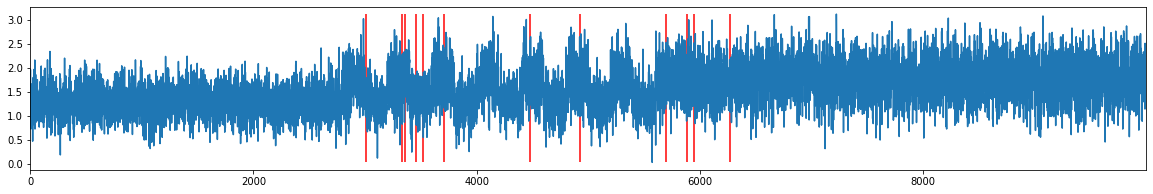

In [151]:
#ADWIN
plot_series_with_single_data_changes(series1,adwin_detector(ser1_arr))

Change in data at value 2.0333887671406496 - at index: 2913
Change in data at value 2.16564279674368 - at index: 3399
Change in data at value 2.00178390435606 - at index: 3714
Change in data at value 2.02543469767642 - at index: 4166
Change in data at value 2.21785831776067 - at index: 4571
Change in data at value 2.0383934952525 - at index: 4963
Change in data at value 2.62538871975583 - at index: 5356
Change in data at value 2.1005444679691396 - at index: 5777
[2913, 3399, 3714, 4166, 4571, 4963, 5356, 5777]


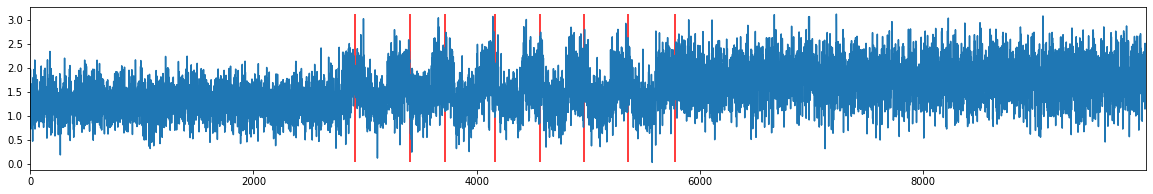

In [152]:
#PAGE-HINKLEY
plot_series_with_single_data_changes(series1,ph_detector(ser1_arr))

###### Series 2

Change in data at value 1.2774575868892 - at index: 3743
Change in data at value 1.18499467777305 - at index: 3807
Change in data at value 1.02733893928192 - at index: 3903
Change in data at value 1.19395568025435 - at index: 3999
Change in data at value 0.887373440921126 - at index: 4351
Change in data at value 1.0697905010200501 - at index: 4511
Change in data at value 1.47806837137173 - at index: 4863
Change in data at value 1.04563724326845 - at index: 5087
Change in data at value 1.70412772798626 - at index: 5311
Change in data at value 0.857289990924157 - at index: 5631
Change in data at value 1.5917972887945901 - at index: 5791
Change in data at value 1.23888747620218 - at index: 6271
Change in data at value 1.43460692903557 - at index: 7679
[3743, 3807, 3903, 3999, 4351, 4511, 4863, 5087, 5311, 5631, 5791, 6271, 7679]


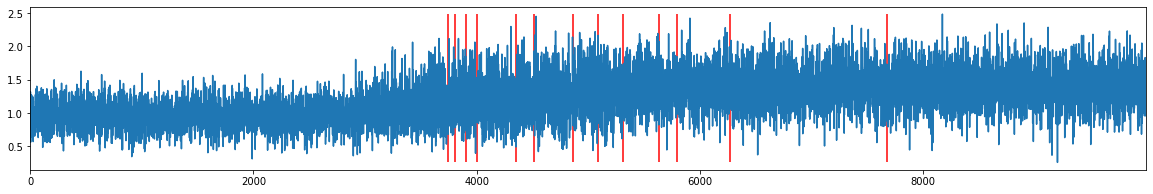

In [153]:
#ADWIN
plot_series_with_single_data_changes(series2,adwin_detector(ser2_arr))

Change in data at value 1.82594218026339 - at index: 3591
Change in data at value 1.8661060346627 - at index: 4871
Change in data at value 2.02188694029355 - at index: 7009
[3591, 4871, 7009]


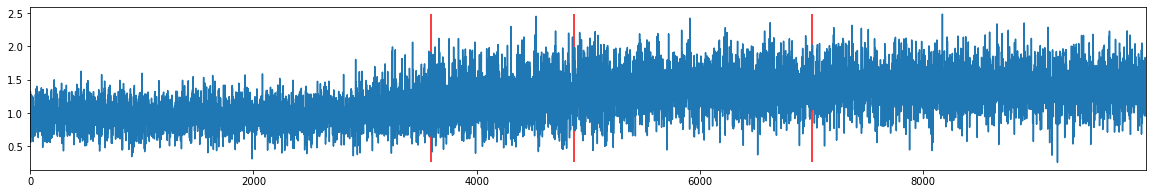

In [154]:
#PAGE-HINKLEY
plot_series_with_single_data_changes(series2,ph_detector(ser2_arr))

###### Series 3

[]


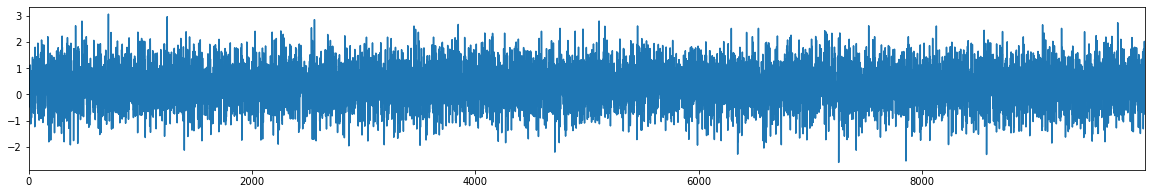

In [156]:
#ADWIN
plot_series_with_single_data_changes(series3,adwin_detector(ser3_arr))

Change in data at value 0.783208418713654 - at index: 4038
[4038]


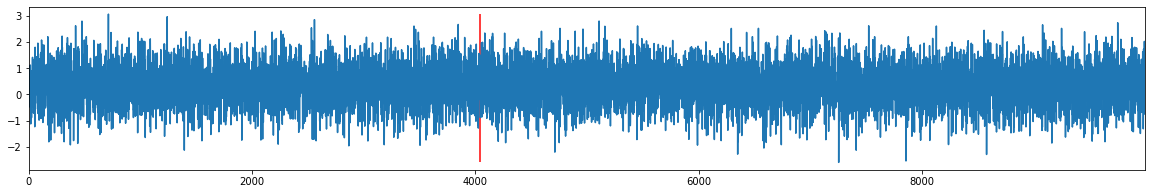

In [155]:
#PAGE-HINKLEY
plot_series_with_single_data_changes(series3,ph_detector(ser3_arr))

#### Merged detectors results

In [126]:
def adwin_page_hinkley_merged_detector(series, margin_threshold=200):
    adwin_changes_list=adwin_detector(series,printout=False)
    ph_changes_list=ph_detector(series,printout=False)
    results=[]
    if len(ph_changes_list) < len (adwin_changes_list):
        short=ph_changes_list
        long=adwin_changes_list
    else:
        long=ph_changes_list
        short=adwin_changes_list
    for elem in long:
        for ref in short:
            if ref-margin_threshold<=elem and elem <=ref+margin_threshold:
                results.append(elem)
    results=list(set(results))
    results.sort()
    return results

In [144]:
def plot_series_with_merged_data_changes(series,series_arr,margin=150):
    changes=adwin_page_hinkley_merged_detector(series_arr,margin)
    print(changes)
    fig= plt.figure(figsize=(20,3))
    series.x.plot()
    plt.vlines(x=changes,ymin=min(series.x), ymax=max(series.x),colors='red')

[3007, 3327, 3359, 3455, 3711, 4479, 4927, 5695]


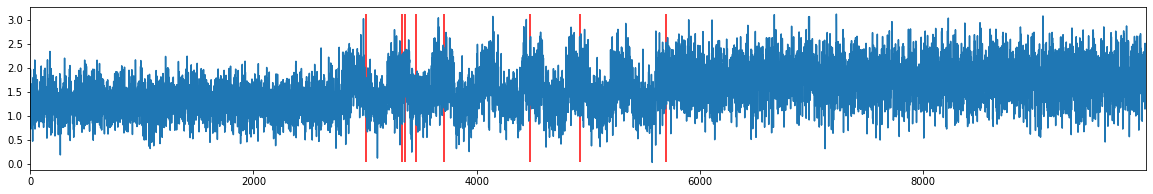

In [145]:
plot_series_with_merged_data_changes(series1,ser1_arr,100)

[3743, 4863]


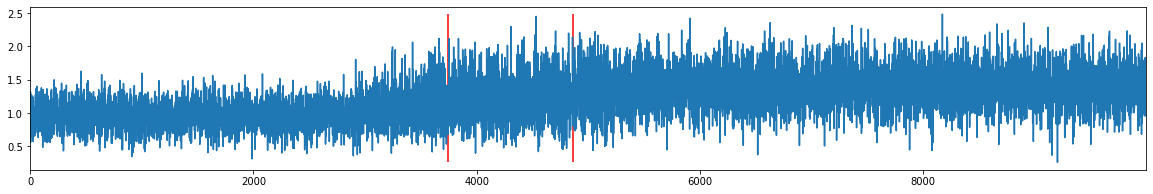

In [146]:
plot_series_with_merged_data_changes(series2,ser2_arr,200)

[]


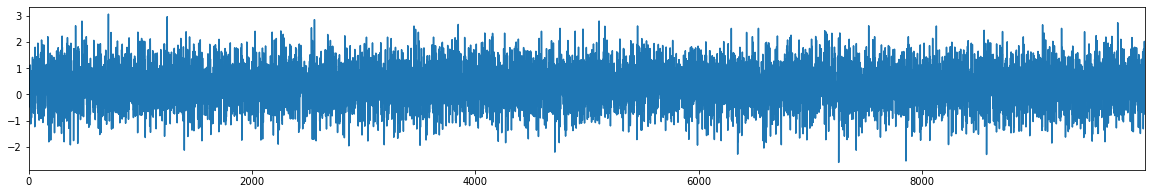

In [147]:
plot_series_with_merged_data_changes(series3,ser3_arr,200)

### Own method

#### Detection of buffer distribution change on new window read

In [513]:
### CHI SQAURED CRITERION
def standarise(series,pct,pct_lower):
    sc = StandardScaler() 
    y=series
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

def chi_ranking(series,pct=0.99,pct_lower=0.01):
    y_std,size,y_org = standarise(series,pct,pct_lower)
#     dist_names = ['weibull_min','norm','weibull_max','beta',
#                  'invgauss','uniform','gamma','expon', 'lognorm','triang']

    dist_names = ['norm','beta','uniform','gamma','expon','lognorm']

    chi_square_statistics = []
    params = []
    # 11 bins
    percentile_bins = np.linspace(0,100,30)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)


    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        params.append(str(param))
#         print("{}\n{}\n".format(dist, param))
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency),0)
        chi_square_statistics.append(ss)

    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['distribution'] = dist_names
    results['value'] = chi_square_statistics
    results.sort_values(['value'], inplace=True)
    return results

In [514]:
### SQUARED ERROR CRITERION
def sumsquare_ranking(series):
    f = fitter.Fitter(series,verbose=False)
#     f.distributions=['weibull_min','norm','weibull_max','beta',
#                      'invgauss','uniform','gamma','expon', 'lognorm','pearson3','triang']
    f.distributions = ['norm','beta','uniform','gamma','expon','lognorm']
    f.fit()
    res=f.summary(Nbest=11, plot=False)
    results = pd.DataFrame()
    results['distribution'] = res.index.to_list()
    results['value'] = res.sumsquare_error.to_list()
    results.sort_values(['value'], inplace=True)
    return results

In [515]:
chi_ranking(STREAM_1[7])

,distribution,value
1,beta,3.0
5,lognorm,20.0
3,gamma,21.0
2,uniform,25.0
0,norm,26.0
4,expon,173.0


In [516]:
sumsquare_ranking(STREAM_1[0])

,distribution,value
0,lognorm,32.781768
1,beta,32.884222
2,gamma,32.889940
3,norm,34.276001
4,uniform,55.265410
5,expon,67.163827


In [517]:
def detect_leader_change(index, old_distribution_results,new_distribution_results):
    new_leader=new_distribution_results.distribution.to_list()[0]
    old_leader=old_distribution_results.distribution.to_list()[0]
    if new_leader != old_leader : 
        print ('\n Change in data detected at index:'+ str(index))
        print ('\n Old distribution:' + old_leader)
        print ('\n New distribution:'+ new_leader)
        print ('............................................')
        print()
        return index,True
    else:
        return index,False

In [534]:
def detect_top_n_change(index, old_distribution_results,new_distribution_results):
    first=old_distribution_results.distribution.to_list()[0]
    second=old_distribution_results.distribution.to_list()[1]
    third=old_distribution_results.distribution.to_list()[2]
    neworder=new_distribution_results.distribution.to_list()
    top_n=[0,1,2]
    if (neworder.index(first) not in top_n)or (neworder.index(second) not in top_n):
        print ('\n Change in data detected at index:'+ str(index))
        print ('\n Old distribution:' + new_distribution_results.distribution.to_list()[0])
        print ('\n New distribution:'+ old_distribution_results.distribution.to_list()[0])
        print ('............................................')
        print()
        return index,True
    else:
        return index,False

In [569]:
def detect_top_2_error_increase(index, old_distribution_results,new_distribution_results,threshold=2.0):
    first=old_distribution_results.distribution.to_list()[0]
    second=old_distribution_results.distribution.to_list()[1]
    third=old_distribution_results.distribution.to_list()[2]
    neworder=new_distribution_results.distribution.to_list()
    new_chi_list=new_distribution_results.value.to_list()
    old_chi_list=old_distribution_results.value.to_list()
    total_old=old_chi_list[0]+old_chi_list[1]+old_chi_list[2]
    total_new=new_chi_list[neworder.index(first)]+new_chi_list[neworder.index(second)]+new_chi_list[neworder.index(third)]
    if(total_new>=threshold*total_old):
        print ('\n Change in data detected at index:'+ str(index))
        print ('\n Old distribution:' + new_distribution_results.distribution.to_list()[0])
        print ('\n New distribution:'+ old_distribution_results.distribution.to_list()[0])
        print ('............................................')
        print()
        return index,True
    else:
        return index,False

In [561]:
def detect_buffer(stream, buffer_size=10,ranking_fun=chi_ranking, change_detector=detect_leader_change):
    window_size=WINDOW_SIZE
    buffer=[]
    results_history=[]
    changes=[]
    ##initialize buffer
    for i in range (buffer_size):
        buffer.extend(stream[i])
    results_history.append(ranking_fun(buffer))
    for i in range (buffer_size,len(stream)):
        buffer=buffer[window_size:]
        buffer.extend(stream[i])
        results=ranking_fun(buffer)
        ind,res=change_detector(i*window_size, results_history[-1],results)
        results_history.append(results)
        if res:
            changes.append(ind)
    return changes

#### Leader change detection

In [521]:
changes_1=detect_buffer(STREAM_1,ranking_fun=chi_ranking,change_detector=detect_leader_change)


 Change in data detected at index:1300

 Old distribution:beta

 New distribution:gamma
............................................


 Change in data detected at index:1400

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2100

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:2200

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2300

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:2500

 Old distribution:gamma

 New distribution:norm
............................................


 Change in data detected at index:2600

 Old distribution:norm

 New distribution:lognorm
............................................


 Change in data detected at index:2700



[1300, 1400, 2100, 2200, 2300, 2500, 2600, 2700, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 6300, 6400, 6700, 6800, 6900, 7000]


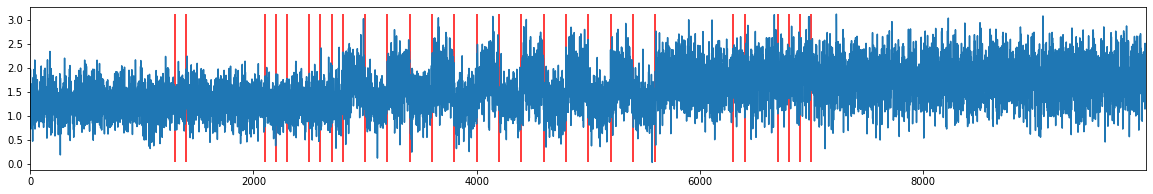

In [522]:
plot_series_with_single_data_changes(series1,changes_1)

In [523]:
changes_2=detect_buffer(STREAM_2,ranking_fun=chi_ranking,change_detector=detect_leader_change)


 Change in data detected at index:1200

 Old distribution:beta

 New distribution:gamma
............................................


 Change in data detected at index:1300

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:1400

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:1500

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2200

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:2300

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2400

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:25

[1200, 1300, 1400, 1500, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3200, 3300, 3400, 3500, 4300, 4400, 6300, 6400, 6600, 6700, 6800, 7000, 7200, 7300, 7400, 7800, 7900, 8000]


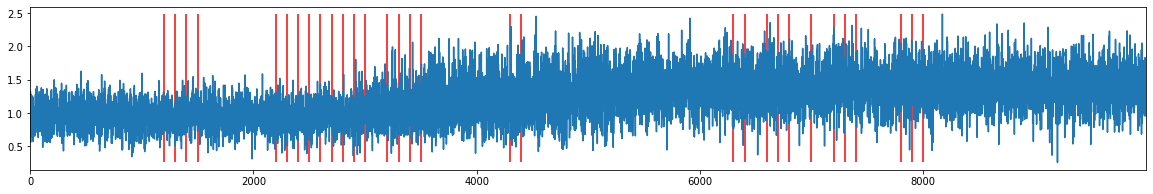

In [525]:
plot_series_with_single_data_changes(series2,changes_2)

In [526]:
changes_3=detect_buffer(STREAM_3,ranking_fun=chi_ranking,change_detector=detect_leader_change)


 Change in data detected at index:1200

 Old distribution:beta

 New distribution:gamma
............................................


 Change in data detected at index:1300

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2100

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:2200

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2300

 Old distribution:lognorm

 New distribution:beta
............................................


 Change in data detected at index:2400

 Old distribution:beta

 New distribution:lognorm
............................................


 Change in data detected at index:2500

 Old distribution:lognorm

 New distribution:norm
............................................


 Change in data detected at index:2600


[1200, 1300, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 5000, 5100, 5400, 5500, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9600, 9700, 9900]


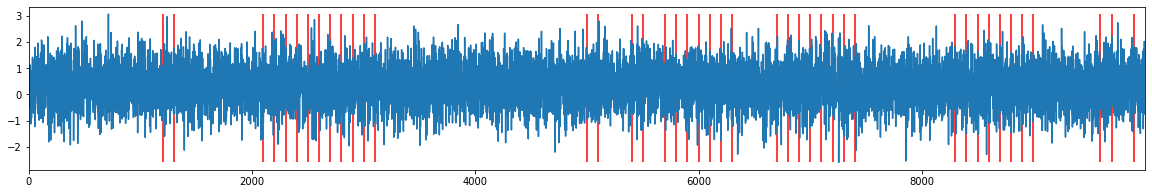

In [527]:
plot_series_with_single_data_changes(series3,changes_3)

#### Top 2 out of top 3 detection

In [535]:
changes_1_top=detect_buffer(STREAM_1,ranking_fun=chi_ranking,change_detector=detect_top_n_change)


 Change in data detected at index:2300

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2500

 Old distribution:norm

 New distribution:gamma
............................................


 Change in data detected at index:2800

 Old distribution:lognorm

 New distribution:norm
............................................


 Change in data detected at index:3000

 Old distribution:norm

 New distribution:lognorm
............................................


 Change in data detected at index:3200

 Old distribution:lognorm

 New distribution:norm
............................................


 Change in data detected at index:3400

 Old distribution:norm

 New distribution:lognorm
............................................


 Change in data detected at index:3600

 Old distribution:lognorm

 New distribution:norm
............................................


 Change in data detected at index:4000

 

[2300, 2500, 2800, 3000, 3200, 3400, 3600, 4000, 4200, 4600, 4900, 5000, 6200, 6300, 6400, 6800, 6900]


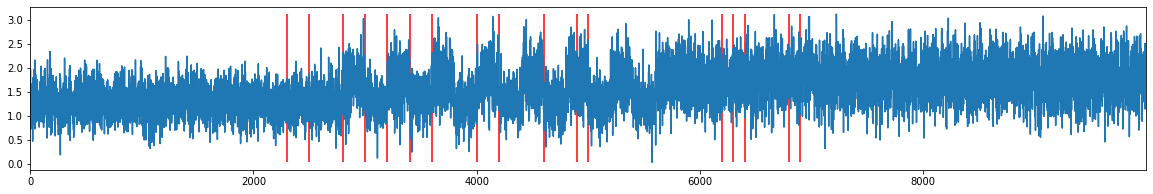

In [536]:
plot_series_with_single_data_changes(series1,changes_1_top)

In [537]:
changes_2_top=detect_buffer(STREAM_2,ranking_fun=chi_ranking,change_detector=detect_top_n_change)


 Change in data detected at index:2300

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:2400

 Old distribution:gamma

 New distribution:lognorm
............................................


 Change in data detected at index:2500

 Old distribution:norm

 New distribution:gamma
............................................


 Change in data detected at index:2600

 Old distribution:gamma

 New distribution:norm
............................................


 Change in data detected at index:2700

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:3000

 Old distribution:lognorm

 New distribution:norm
............................................


 Change in data detected at index:3500

 Old distribution:lognorm

 New distribution:norm
............................................


 Change in data detected at index:6600

 

[2300, 2400, 2500, 2600, 2700, 3000, 3500, 6600, 7000, 7100, 7200, 7900]


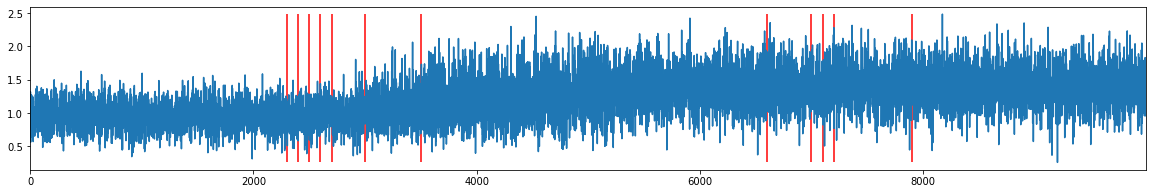

In [538]:
plot_series_with_single_data_changes(series2,changes_2_top)

In [539]:
changes_3_top=detect_buffer(STREAM_3,ranking_fun=chi_ranking,change_detector=detect_top_n_change)


 Change in data detected at index:2400

 Old distribution:lognorm

 New distribution:beta
............................................


 Change in data detected at index:5000

 Old distribution:lognorm

 New distribution:beta
............................................


 Change in data detected at index:5400

 Old distribution:norm

 New distribution:beta
............................................


 Change in data detected at index:5700

 Old distribution:lognorm

 New distribution:beta
............................................


 Change in data detected at index:6200

 Old distribution:norm

 New distribution:beta
............................................


 Change in data detected at index:6700

 Old distribution:lognorm

 New distribution:beta
............................................


 Change in data detected at index:6900

 Old distribution:norm

 New distribution:beta
............................................


 Change in data detected at index:7100

 Old dist

[2400, 5000, 5400, 5700, 6200, 6700, 6900, 7100, 7300, 8300, 8500, 9600, 9900]


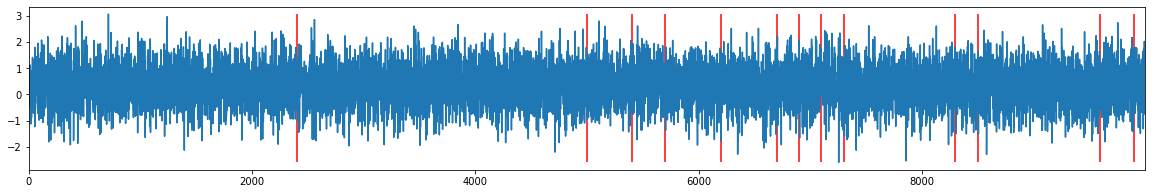

In [540]:
plot_series_with_single_data_changes(series3,changes_3_top)

#### Top 3 error increase detection

In [570]:
changes_1_error=detect_buffer(STREAM_1,ranking_fun=chi_ranking,change_detector=detect_top_2_error_increase)


 Change in data detected at index:1000

 Old distribution:beta

 New distribution:beta
............................................


 Change in data detected at index:1800

 Old distribution:lognorm

 New distribution:lognorm
............................................


 Change in data detected at index:3400

 Old distribution:norm

 New distribution:lognorm
............................................


 Change in data detected at index:4900

 Old distribution:lognorm

 New distribution:lognorm
............................................


 Change in data detected at index:5400

 Old distribution:beta

 New distribution:lognorm
............................................



[1000, 1800, 3400, 4900, 5400]


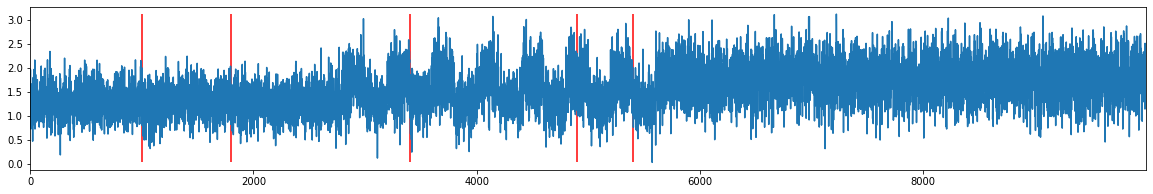

In [571]:
plot_series_with_single_data_changes(series1,changes_1_error)

In [572]:
changes_2_error=detect_buffer(STREAM_2,ranking_fun=chi_ranking,change_detector=detect_top_2_error_increase)


 Change in data detected at index:1000

 Old distribution:beta

 New distribution:beta
............................................


 Change in data detected at index:1500

 Old distribution:lognorm

 New distribution:gamma
............................................


 Change in data detected at index:1600

 Old distribution:lognorm

 New distribution:lognorm
............................................


 Change in data detected at index:4000

 Old distribution:lognorm

 New distribution:lognorm
............................................


 Change in data detected at index:4700

 Old distribution:lognorm

 New distribution:lognorm
............................................


 Change in data detected at index:7900

 Old distribution:norm

 New distribution:lognorm
............................................



[1000, 1500, 1600, 4000, 4700, 7900]


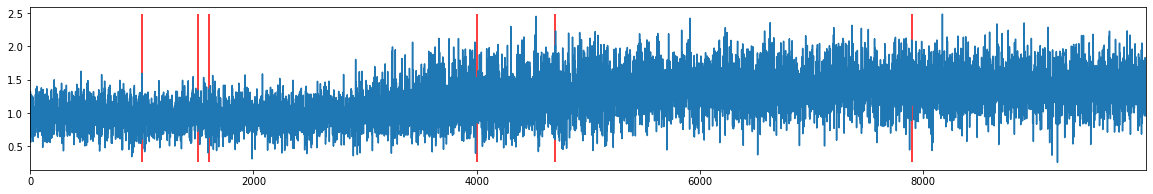

In [573]:
plot_series_with_single_data_changes(series2,changes_2_error)

In [574]:
changes_3_error=detect_buffer(STREAM_3,ranking_fun=chi_ranking,change_detector=detect_top_2_error_increase)


 Change in data detected at index:1000

 Old distribution:beta

 New distribution:beta
............................................


 Change in data detected at index:1400

 Old distribution:lognorm

 New distribution:lognorm
............................................


 Change in data detected at index:5000

 Old distribution:lognorm

 New distribution:beta
............................................


 Change in data detected at index:5400

 Old distribution:norm

 New distribution:beta
............................................


 Change in data detected at index:5700

 Old distribution:lognorm

 New distribution:beta
............................................


 Change in data detected at index:6000

 Old distribution:lognorm

 New distribution:norm
............................................


 Change in data detected at index:6200

 Old distribution:norm

 New distribution:beta
............................................


 Change in data detected at index:6700

 Old d

[1000, 1400, 5000, 5400, 5700, 6000, 6200, 6700, 6900, 7100, 7300, 8300, 8500, 9600, 9900]


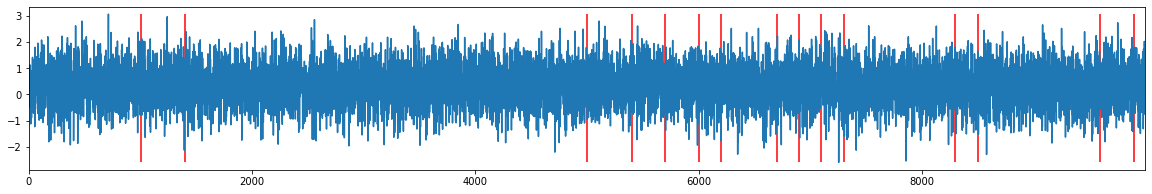

In [575]:
plot_series_with_single_data_changes(series3,changes_3_error)

## Outcomes
- The Page-Hinkley algorithm seems to be the best
- In some cases, combined ADWIN and Page-Hinkley algorithms achieve better results, sometimes worse than Page-Hinkley
- Detection of distribution list leader change seems to be too sensitive
- Leaderboard change detection seems to give satisfactory results
- Detection of an increase in the error of the top distributions from the list seems to be too insensitive to changes

In [ ]:
def detect_buffer(stream, buffer_size=10,ranking_fun=chi_ranking, change_detector=detect_leader_change):
    window_size=WINDOW_SIZE
    buffer=[]
    results_history=[]
    changes=[]
    ##initialize buffer
    for i in range (buffer_size):
        buffer.extend(stream[i])
    results_history.append(ranking_fun(buffer))
    for i in range (buffer_size,len(stream)):
        buffer=buffer[window_size:]
        buffer.extend(stream[i])
        results=ranking_fun(buffer)
        ind,res=change_detector(i*window_size, results_history[-1],results)
        results_history.append(results)
        if res:
            changes.append(ind)
    return changes